In [ ]:
!wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/TrainIJCNN2013.zip

--2024-11-11 07:48:42--  https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/TrainIJCNN2013.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1104177081 (1.0G) [application/zip]
Saving to: ‘TrainIJCNN2013.zip’

TrainIJCNN2013.zip  100%[===================>]   1.03G  12.9MB/s    in 63s     

2024-11-11 07:49:46 (16.7 MB/s) - ‘TrainIJCNN2013.zip’ saved [1104177081/1104177081]



In [ ]:
!unzip TrainIJCNN2013.zip -d TrainIJCNN2013

Archive:  TrainIJCNN2013.zip
   creating: TrainIJCNN2013/TrainIJCNN2013/
   creating: TrainIJCNN2013/TrainIJCNN2013/00/
  inflating: TrainIJCNN2013/TrainIJCNN2013/00000.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00001.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00002.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00003.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00004.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00005.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00006.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00007.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00008.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00009.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00010.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00011.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00012.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00013.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00014.ppm  
  inflating: TrainIJCNN2013/TrainIJCNN2013/00015.ppm  


In [10]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
im=cv.imread("/content/TrainIJCNN2013/TrainIJCNN2013/00005.ppm",1)

print (im.shape)
im=cv.cvtColor(im,cv.COLOR_BGR2RGB)
H=im.shape[0]
W=im.shape[1]
plt.figure(figsize=(20,20))
plt.imshow(im)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
HSV=cv.cvtColor(im,cv.COLOR_RGB2HSV)
plt.figure(figsize=(20,20))
plt.imshow(HSV)

Output hidden; open in https://colab.research.google.com to view.

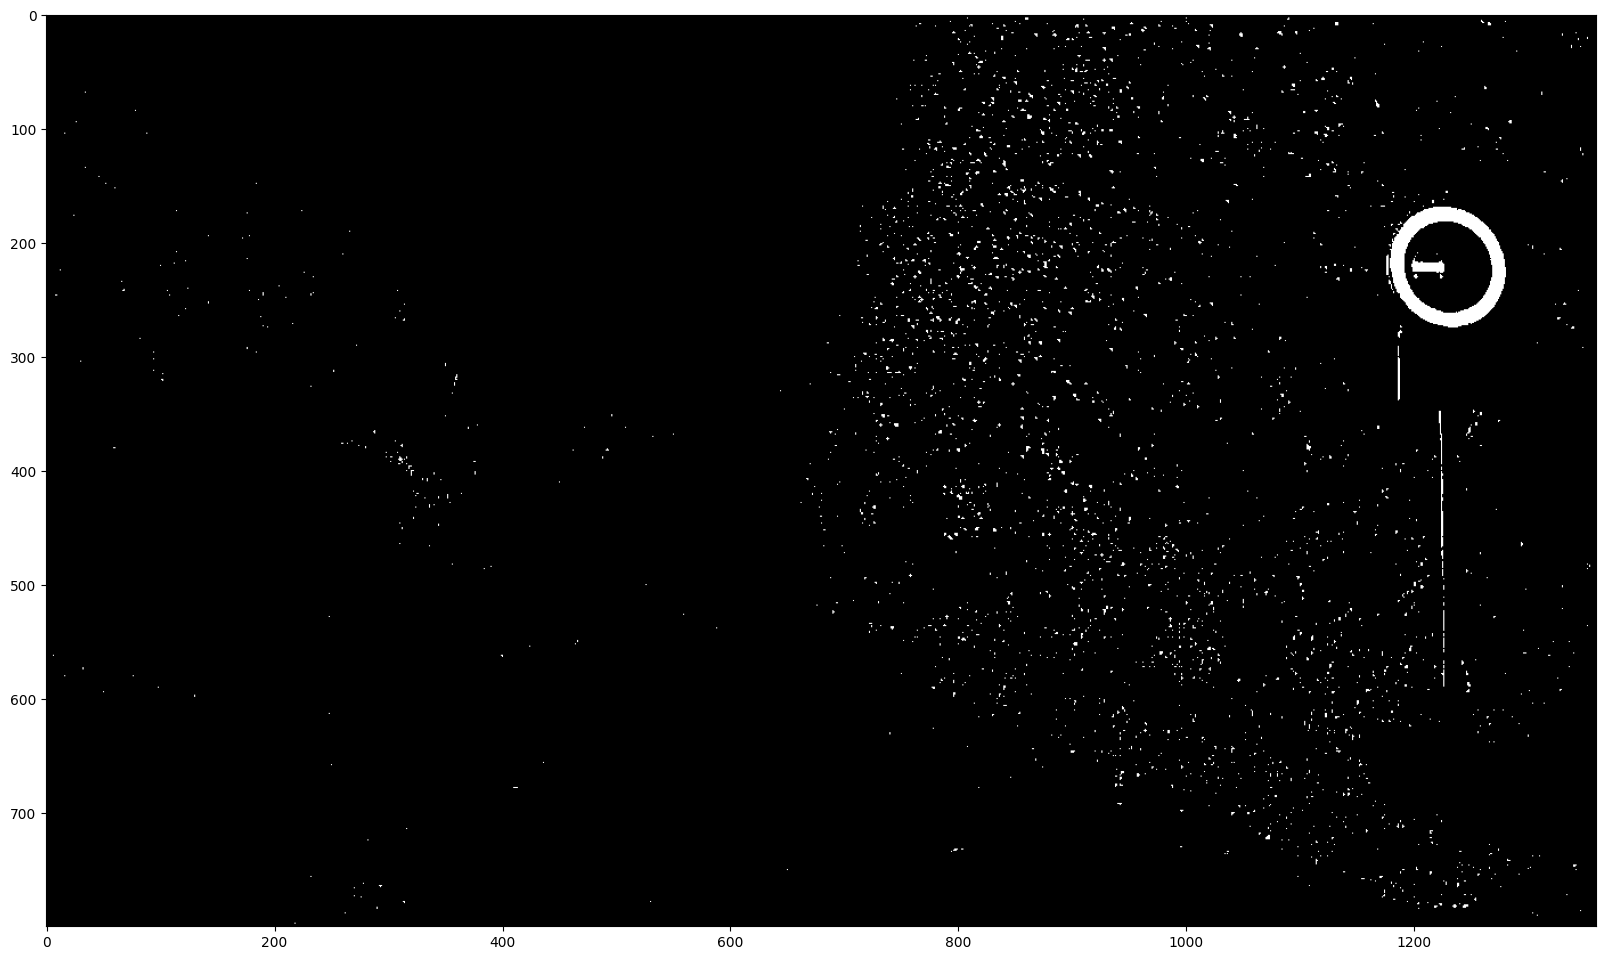

In [69]:
bin1=cv.inRange(HSV, (0,80,0),(12,255,255))
bin2=cv.inRange(HSV, (168,80,0),(180,255,255))
bin=cv.bitwise_or(bin1,bin2)
plt.figure(figsize=(20,20))
plt.imshow(bin,cmap='gray')

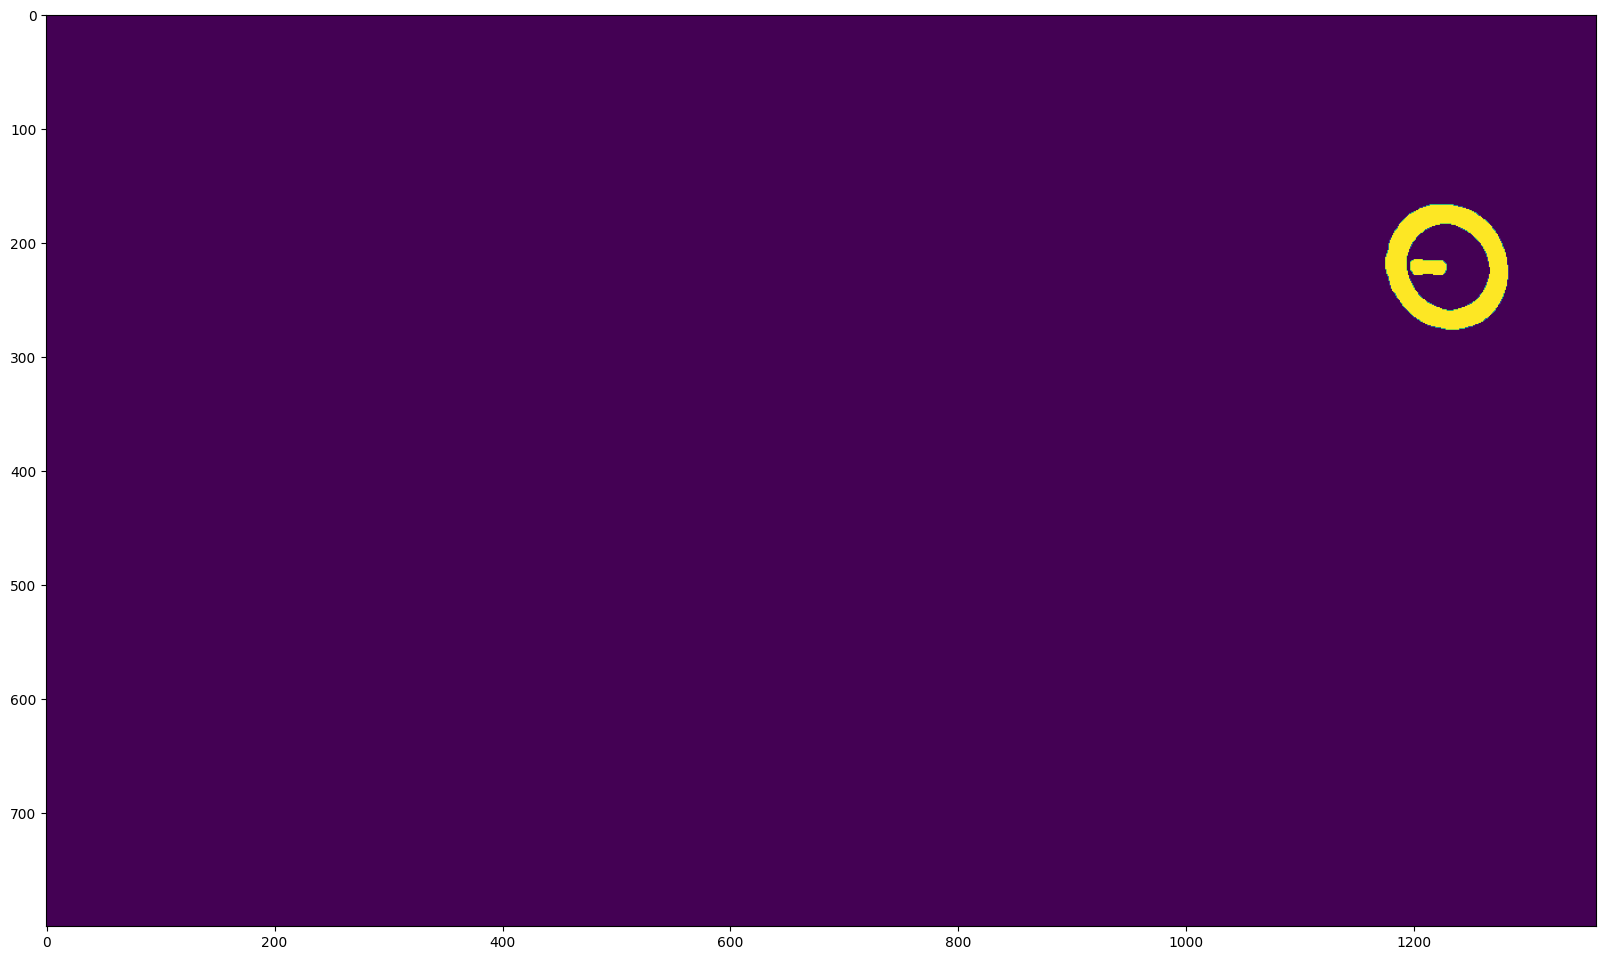

In [68]:
dst=cv.medianBlur(bin,9)
kernel = np.ones((5,5),np.uint8)
dilate_dst=cv.dilate(dst,kernel)
plt.figure(figsize=(20,20))
plt.imshow(dilate_dst)

Number of contours: 1


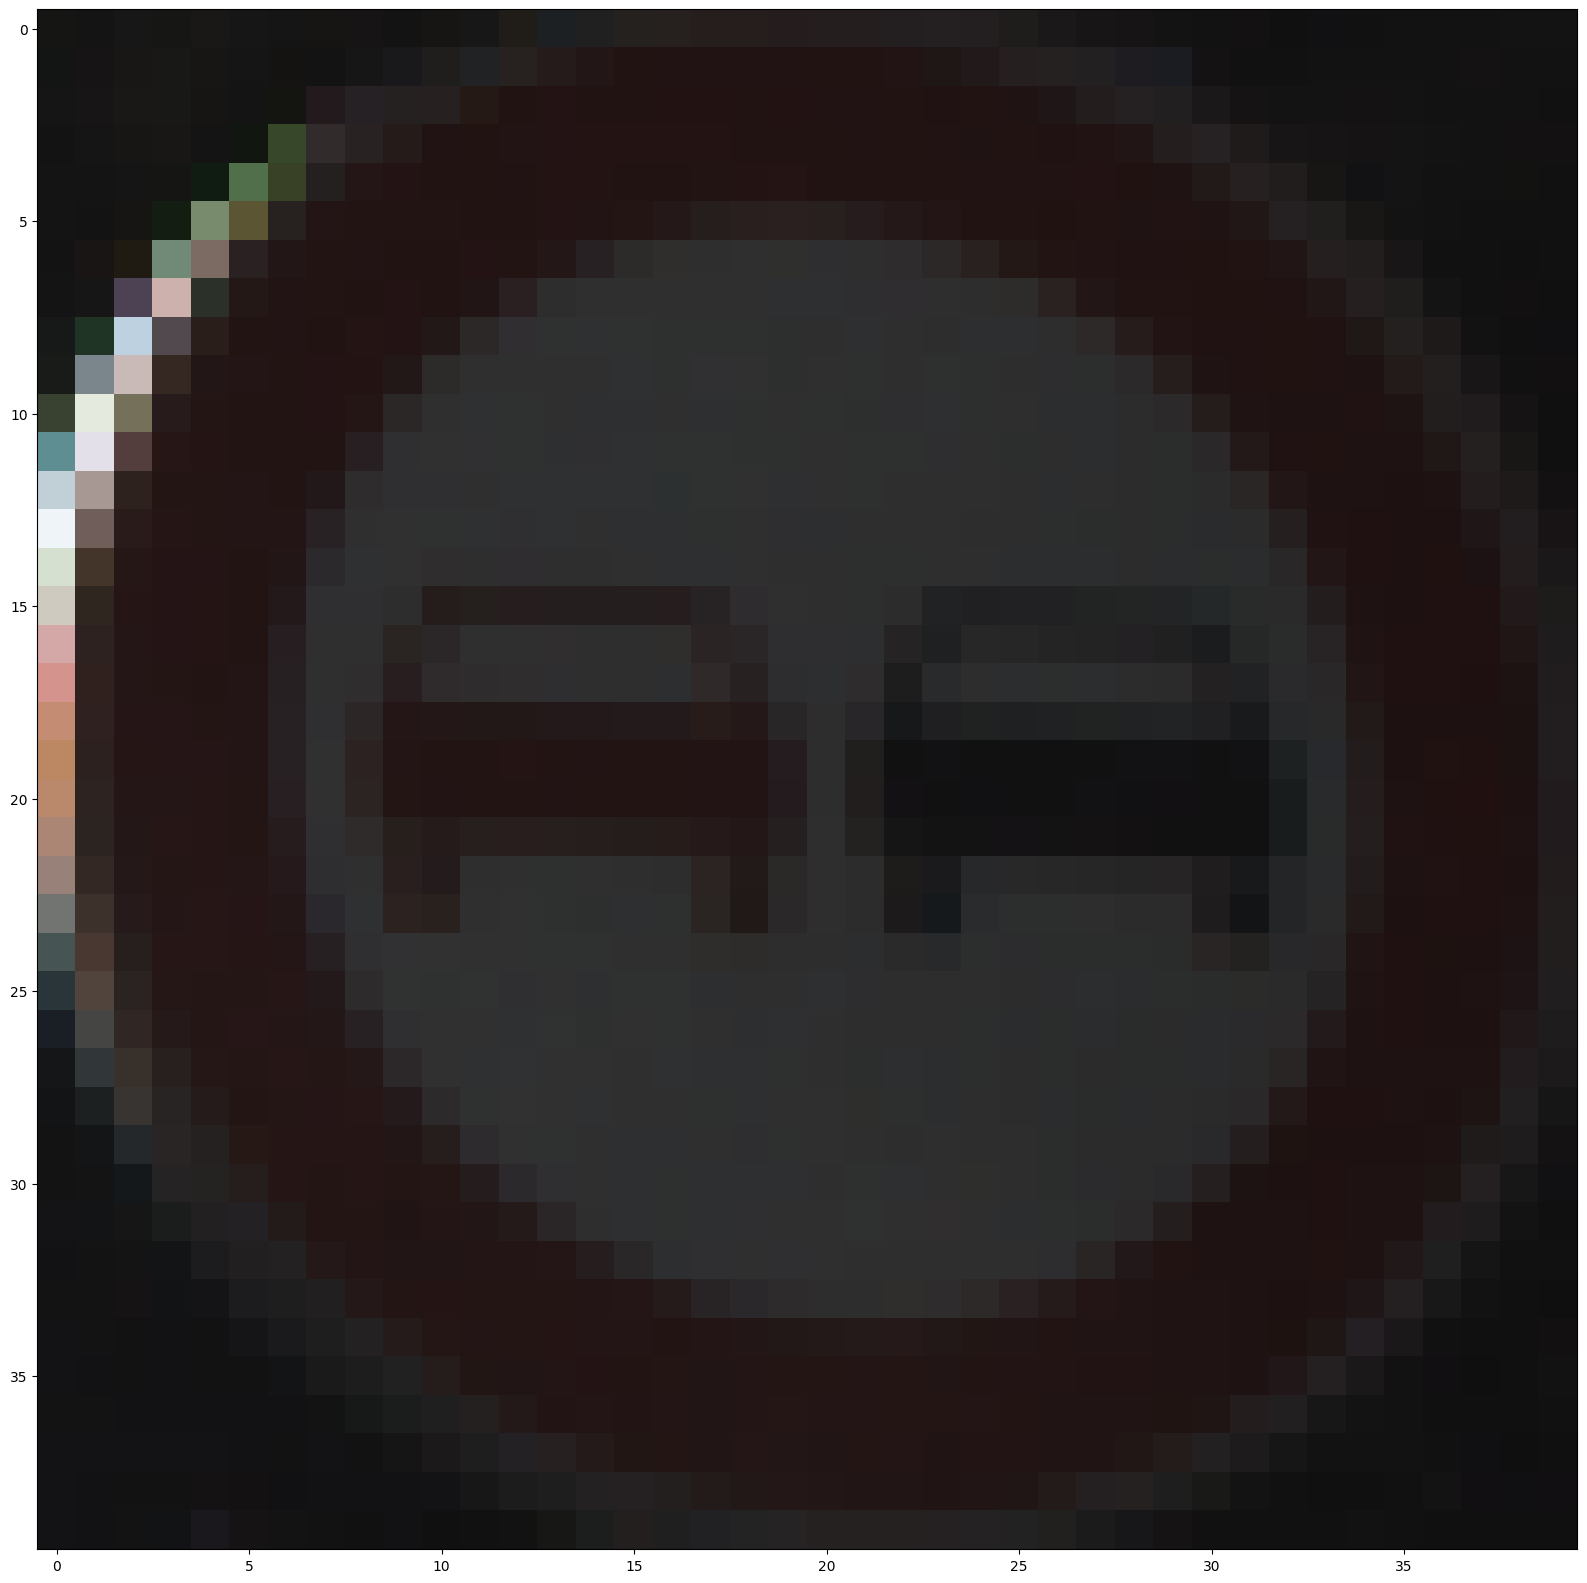

In [67]:
contours, _ = cv.findContours(dilate_dst, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
Rois=[]
Rect=[]
print("Number of contours: " +str(len(contours)))
for c in contours:
  x,y,w,h=cv.boundingRect(c)
  if h>H/35 and w>W/35 and h<H/3 and w<W/3:
    roi=im[y:y+h,x:x+w]
    resized=cv.resize(roi,(40,40),interpolation=cv.INTER_AREA)
    Rois.append(resized)
    Rect.append(cv.boundingRect(c))
plt.figure(figsize=(20,20))
plt.imshow(Rois[0])

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import numpy as np

In [104]:
from skimage.feature import hog
from skimage import exposure

hog_features = []
for roi in Rois:
    # Convert the ROI to grayscale (since HOG typically operates on single-channel images)
    roi_gray = cv.cvtColor(roi, cv.COLOR_RGB2GRAY)

    # Extract HOG features from the ROI
    fd, hog_image = hog(roi_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Optionally, you can scale the image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Append the feature descriptor to the list
    hog_features.append(fd)


In [108]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from PIL import Image
import os

# Load and preprocess the dataset
def load_data(data_dir):
    images = []
    labels = []
    for category in os.listdir(data_dir):
        category_dir = os.path.join(data_dir, category)
        if os.path.isdir(category_dir):  # Ensure we're processing a directory
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm')):  # Check for image file extensions
                    img = Image.open(img_path)
                    img = img.resize((32, 32))  # Resize to the desired size
                    img = np.array(img)
                    images.append(img)
                    labels.append(category)
    images = np.array(images)
    labels = np.array(pd.get_dummies(labels))  # One-hot encoding for labels
    return images, labels

# Split the dataset into training and validation sets
data_dir = './TrainIJCNN2013'  # Update with the correct path
images, labels = load_data(data_dir)
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the images
x_train = x_train / 255.0
x_val = x_val / 255.0

# Flatten the images to be used with an ANN
x_train_flat = x_train.reshape(-1, 32 * 32 * 3)  # Flatten the image into a 1D vector
x_val_flat = x_val.reshape(-1, 32 * 32 * 3)  # Flatten the image into a 1D vector

# Build the ANN model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(32 * 32 * 3,)),  # Input layer
    layers.Dense(64, activation='relu'),  # Hidden layer
    layers.Dense(32, activation='relu'),  # Another hidden layer (optional)
    layers.Dense(labels.shape[1], activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train_flat, y_train, epochs=10, validation_data=(x_val_flat, y_val))

# Evaluate the model
val_loss, val_acc = model.evaluate(x_val_flat, y_val)
print(f"Validation accuracy: {val_acc * 100:.2f}%")

# Save the model if needed
model.save('traffic_sign_recognition_ann_model.h5')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0

Validation accuracy: 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


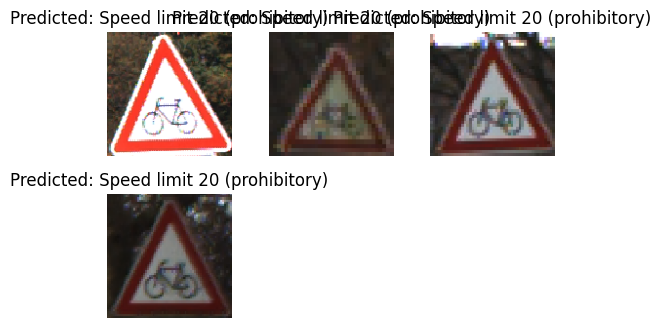

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os

# Load the model
model = load_model('/content/traffic_sign_recognition_model.h5')

# Map ClassIDs to human-readable labels
class_id_to_label = {
    0: 'Speed limit 20 (prohibitory)',
    1: 'Speed limit 30 (prohibitory)',
    2: 'Speed limit 50 (prohibitory)',
    3: 'Speed limit 60 (prohibitory)',
    4: 'Speed limit 70 (prohibitory)',
    5: 'Speed limit 80 (prohibitory)',
    6: 'Restriction ends 80 (other)',
    7: 'Speed limit 100 (prohibitory)',
    8: 'Speed limit 120 (prohibitory)',
    9: 'No overtaking (prohibitory)',
    10: 'No overtaking (trucks) (prohibitory)',
    11: 'Priority at next intersection (danger)',
    12: 'Priority road (other)',
    13: 'Give way (other)',
    14: 'Stop (other)',
    15: 'No traffic both ways (prohibitory)',
    16: 'No trucks (prohibitory)',
    17: 'No entry (other)',
    18: 'Danger (danger)',
    19: 'Bend left (danger)',
    20: 'Bend right (danger)',
    21: 'Bend (danger)',
    22: 'Uneven road (danger)',
    23: 'Slippery road (danger)',
    24: 'Road narrows (danger)',
    25: 'Construction (danger)',
    26: 'Traffic signal (danger)',
    27: 'Pedestrian crossing (danger)',
    28: 'School crossing (danger)',
    29: 'Cycles crossing (danger)',
    30: 'Snow (danger)',
    31: 'Animals (danger)',
    32: 'Restriction ends (other)',
    33: 'Go right (mandatory)',
    34: 'Go left (mandatory)',
    35: 'Go straight (mandatory)',
    36: 'Go right or straight (mandatory)',
    37: 'Go left or straight (mandatory)',
    38: 'Keep right (mandatory)',
    39: 'Keep left (mandatory)',
    40: 'Roundabout (mandatory)',
    41: 'Restriction ends (overtaking) (other)',
    42: 'Restriction ends (overtaking trucks) (other)'
}

# Function to preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(32, 32))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

# Directory containing new test images
test_images_dir = '/content/TrainIJCNN2013/TrainIJCNN2013/29'  # Update with your test images directory path

# Create a figure to display the images
plt.figure(figsize=(5, 5))

# Load and predict each image
for i, image_name in enumerate(os.listdir(test_images_dir)):
    image_path = os.path.join(test_images_dir, image_name)
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Get the human-readable label for the predicted class
    predicted_label = class_id_to_label[predicted_class]

    # Load image for displaying
    img = load_img(image_path, target_size=(128, 128))  # Resize for better visibility in plot
    plt.subplot(3, 3, i + 1)  # Adjust the grid size based on the number of images
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')

    if i == 8:  # Limiting the number of images displayed to 9
        break

plt.tight_layout()
plt.show()
